In [8]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import selectivesearch

from nms import non_max_supression_slow

import chainer
import chainer.functions as F
from chainer import iterators

from chainercv.datasets import directory_parsing_label_names
from chainercv.datasets import DirectoryParsingLabelDataset
from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

from chainercv.utils import apply_prediction_to_iterator
from chainercv.utils import ProgressHook
from chainercv.utils import read_image

%matplotlib inline 

In [2]:
with open('./clsid_to_name.txt', 'r') as f:
    classes = list(map(lambda l: l.strip(), f.readlines()))

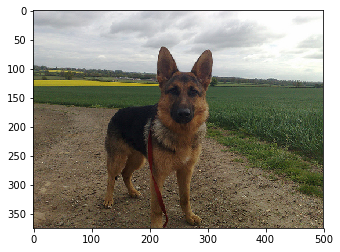

In [9]:
#img=mpimg.imread("/data/unagi0/ilsvrc2017/ILSVRC/Data/DET/val/ILSVRC2012_val_00043168.JPEG")
img=mpimg.imread("/data/unagi0/ilsvrc2017/ILSVRC/Data/DET/val/ILSVRC2012_val_00043054.JPEG")
plt.imshow(img)

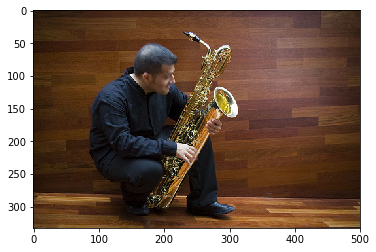

In [193]:
img=read_image("/data/unagi0/ilsvrc2017/ILSVRC/Data/DET/val/ILSVRC2012_val_00043168.JPEG")
plt.imshow(np.moveaxis(img, 0, -1).astype(dtype=np.uint8))

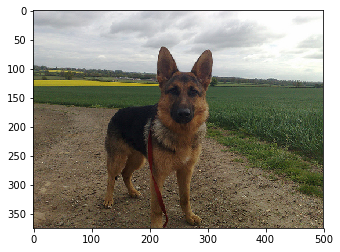

In [3]:
img=mpimg.imread("/data/unagi0/ilsvrc2017/ILSVRC/Data/DET/val/ILSVRC2012_val_00043054.JPEG")
img_lbl, regions = selectivesearch.selective_search(img, scale=30, sigma=0.90, min_size=10)
candidates = list()
for r in regions:
    if r['rect'] in candidates:
        continue
    if r['size'] < 400: 
        continue
    x,y,w,h = r['rect']
    if w <= 100 or h <= 100:
        continue
    candidates.append(r['rect'])
    # cv2.rectangle(img, (x, y), (x+w, y+h), 0xFF3333, thickness=2)
plt.imshow(img)

In [70]:
x, y, w, h = regions[12]['rect']
#cv2.rectangle(img, (x, y), (x+w, y+h), 0xFF3333, thickness=2)

In [18]:
img.dtype

dtype('uint8')

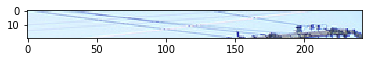

In [71]:
cropped_image = img[y:y+h,x:x+w,:]
plt.imshow(cropped_image)

In [143]:
extractor = VGG16(1000, 'imagenet')
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')
prob = model.predict([img])

From: https://github.com/yuyu2172/share-weights/releases/download/0.0.4/vgg16_imagenet_convert_2017_07_18.npz
To: /home/mil/james/.chainer/dataset/_dl_cache/8694d96c4c410ac4dd44458a3750dfaa
  %   Total    Recv       Speed  Time left
  2  490MiB   11MiB     57KiB/s    2:23:13

KeyboardInterrupt: 

In [141]:
np.argmax(prob)

776

In [4]:
cropped_images = list()
for region in candidates:
    x,y,w,h = region  
    cropped_images.append(np.moveaxis(img[y:y+h,x:x+w,:],2,0).astype(np.float32))

In [5]:
len(cropped_images)

48

In [6]:
extractor = VGG16(1000, 'imagenet')
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')

In [25]:
prob = model.predict(cropped_images)

In [28]:
for i, p in enumerate(prob):
    if np.max(p) > 0.6:
        print("%d: class: %s\t\tprob: %f" % (i, classes[np.argmax(p)], np.max(p) ))

28: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.984662
29: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.922484
30: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.871821
31: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.847578
33: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.947030
34: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.990481
35: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.977120
36: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.812923
39: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob: 0.971092
41: class: 235: 'German shepherd, German shepherd dog, German police dog, alsatian',		prob:

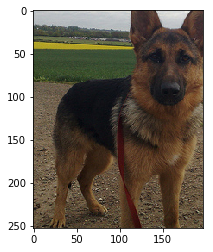

In [34]:
plt.imshow(np.moveaxis(cropped_images[35],0,2).astype(np.uint8))